<a href="https://colab.research.google.com/github/dleegithub/NeuralNetworkTutorial/blob/main/Copia_para_Jesus_Solving_HD_DPP_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving High-Dimensional Dynamic Programming Problems using Deep Learning

If you spot any mistakes, please email me at r.maura-rivero@lse.ac.uk .

To run the entire notebook yourself, use Ctrl + 9, or go cell by cell executing with a click. 

## Why are you using Google Colab?

With Colab you can play with this code without installing anything. From any browser. 

If you want a tutorial (although it is not needed), visit https://research.google.com/colaboratory/ . 
 


## Introduction
The problem that we are trying to solve in this notebook is the Neoclassical Growth Model:





> $\rho V(k)=\max_{c}U(c)+V'(k)[F(k)-\delta k-c]$

To do so, we will approximate both the value function and the consumption with a neural network

> $\tilde{C}(k;\Theta^{C})$  \\
> $\tilde{V}(k;\Theta^{V})$






In [ ]:
#########################################################################################
# Authors: Maximilian J. Vogler, George L. Sorg-Langhans, Roberto-Rafael Maura-Rivero   #
# Start Date: 04/19/2020							                    				#
# Last Modification Date: 09/10/2021										            #
# Purpose: Run NGM code with consumption network							            #
#########################################################################################

## Import libraries
import matplotlib
#matplotlib.use('TkAgg') # Required to make it run on both Windows and Mac
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import os
from tqdm import trange

# Switch of unnecessary TF warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Parameters of the model:**

$\gamma=2.0 \quad$ risk-aversion parameter 

$\rho=0.04 \quad$ 	time preference parameter

$\delta = 0.05 \quad$ 	capital depreciation 

$ \text{TFP} =	0.5 \quad$ 	capital depreciation (A)


In [ ]:
###############################################################################
################################## Parameters #################################
###############################################################################

gamma = tf.constant(2.0)           # Curvature of the utility function
rho   = tf.constant(0.04)          # Discount rate
A      = tf.constant(0.5)          # TFP
alpha = tf.constant(0.36)          # Returns to scale
delta = tf.constant(0.05)          # Depreciation Rate of Capital

batchSize = 1000                   # Batch Size
number_epochs = 200000            # Number of epochs
lowest_iteration = 0
min_loss = 100000

kMin = 0.1                         # lower bound of sample interval
kMax = 10.0                        # upper bound of sample interval

gridSize = 10000                  # Plotting grid

# Set global seed
tf.random.set_seed(42)
np.random.seed(42)

# Value function initial guess
VFInitGuess = -60

# Neural network optimizer
optimizer = keras.optimizers.Adam()

# ergodic distribution estimation
nBurnedIter = 0                    # number of periods iterated to move away from starting point (called B1 in the paper)

Now we will define a function  *valueFnNeuralNet()*  that provides us with a NN when called. This particular NN has 3 hidden layers and 8 neurons per hidden layer.

In [ ]:
###############################################################################
######################## Value Function Neural Network ########################
###############################################################################

def NeuralNet(nHidden = 3, nNeurons = 8, initGuess = 0):
	model = keras.models.Sequential()

	# Input layer
	model.add(keras.layers.Dense(nNeurons, activation = "tanh", input_dim = 1))

	# Hiden layers
	for layer in range(nHidden - 1):
		model.add(keras.layers.Dense(nNeurons, activation = "tanh"))

	# Output layer
	model.add(keras.layers.Dense(1,bias_initializer = keras.initializers.Constant(value = initGuess)))
	return model

Now we will define the Loss function. Like in the paper, this will be the addition of 2 errors: the HJB error (that is, by how much the HJB equation doesn't hold) and the boundary condition ($k(t) \geq 0 , \forall t$). \\



*  $err_{HJB}=\rho\tilde{V}(k;\Theta)-U\left((U')^{-1}\left(\frac{\partial\tilde{V}(k;\Theta)}{\partial k}\right)\right) -\frac{\partial\tilde{V}(k;\Theta)}{\partial k}\left[F(k)-\delta k-(U')^{-1}\left(\frac{\partial\tilde{V}(k;\Theta)}{\partial k}\right)\right]$
*   $err_{\text{boundary}} =  \text{min} \{ 0, k(t+dt) \}$

* $err_{C} = C - U^{-1} \left( V'(k)\right)$

* $Loss = \left\lVert err_{HJB} \right\rVert + \Psi \times \left\lVert err_{\text{boundary}} \right\rVert$

Where, 
$$ k(t+dt) = k(t) + dt \times \frac{\partial k(t)}{\partial t}$$

and $\Psi$ is a large penalization value. The reason behind the need for this value $\Psi$ is the following: an equality condition numerically will (almost) never hold in the computer. It can get very close, but we really do not expect to get 0 error here. However, an inequality condition is a different business. The equation can be (and should be) holding. To express this, we give a bigger weight to the inequality boundary condition. \\


Alternatively, **in this particular exercise**, we could also rewrite the boundary condition as $\exists \epsilon > 0 \left( k(t) \leq \epsilon \Rightarrow \dot{k}(t)\geq 0 \right)$. This would speed up the convergence. However, we choose the previous method given that it covers more general dynamic programming problems (e.g. a situation where the capital slowly decreases until it reaches 0). 

Under the alternative case, 

*   $err_{\text{boundary}} = 0\quad \quad  \text{if} \quad k\geq\epsilon$ 
* $err_{\text{boundary}} = \min \left \{0, \dot{k}\right \} \\ = \min \left \{0, \left[F(k)-\delta k-(U')^{-1}\left(\frac{\partial\tilde{V}(k;\Theta)}{\partial k}\right)\right]\right \} \quad \text{if} \quad k<\epsilon$ 

In [ ]:
def HJB(k_capital, V, C):
    VPrime = tf.gradients(V(k_capital), k_capital)[0]
    # VPrimemax = tf.maximum(VPrime, 1E-7)		# dV/dk

    Y = A * tf.pow(k_capital, alpha)				# Output

    I = Y - tf.exp(C(k_capital))					# Investment

    muK = I - delta * k_capital  					# Capital drift

    U = tf.pow(tf.exp(C(k_capital)), 1-gamma) / (1-gamma) 	# Utility
    # HJB = U - rho * V(k_capital) + tf.multiply(tf.stop_gradient(VPrimemax), muK)
    HJB = U - rho * V(k_capital) + tf.multiply(tf.stop_gradient(VPrime), muK)
    return HJB 

def ergodic_distribution(k_capital, V, C): 
    # iterate the points to estimate the ergodic distribution
    for i in range(nBurnedIter):    
        VPrime = tf.gradients(V(k_capital), k_capital)[0]
        VPrimemax = tf.maximum(VPrime, 1E-7)		    # dV/dk
        Y = A * tf.pow(k_capital, alpha)				# Output
        I = Y - tf.exp(C(k_capital)) 				    # Investment
        dK_dt = I - delta * k_capital  					# Capital drift
        k_capital = k_capital + tf.math.multiply(dt , dK_dt)    # k(t+1) = k(t) + dt*dK_dt
    return k_capital


def boundary_condition_ergodic_1_step (k_capital, V, C):
    VPrime = tf.gradients(V(k_capital), k_capital)[0]
    VPrimemax = tf.maximum(VPrime, 1E-7)		# dV/dk
    Y = A * tf.pow(k_capital, alpha)			# Output
    C = tf.exp(C(k_capital))        			# Consumption
    I = Y - C 									# Investment
    dK_dt = I - delta * k_capital  				# Capital drift
    dt = 0.1
    k_capital_t_plus_one = k_capital + tf.math.multiply(dt , dK_dt)

    # we require kmin < k (t + 1) < kMax 
    error_lowerbound = tf.math.maximum(tf.constant([kMin]) - k_capital_t_plus_one, 0)
    error_upperbound = tf.math.maximum(k_capital_t_plus_one - tf.constant([kMax]), 0)
    error = error_lowerbound + error_upperbound
    return error

def boundary_condition(k_capital, V, C):
    Y = A * tf.pow(k_capital, alpha)			# Output
    I = Y - tf.exp(C(k_capital)) 				# Investment
    dK_dt = I - delta * k_capital  				# Capital drift

    epsilon = 1                                 # values close enought to 0 can't have decreasing capital

    error = tf.where((k_capital < epsilon) & (dK_dt < 0) , dK_dt, 0)
    return error

def C_error(k_capital, V, C):
	VPrime = tf.gradients(V(k_capital), k_capital)[0]
	VPrimemax = tf.maximum(VPrime, 1E-7)
	C_err = tf.pow(VPrimemax, (-1/gamma)) - tf.exp(C(k_capital))
	return C_err

def Loss_function(batchSize):
    k_capital = tf.random.uniform(shape = (batchSize,1), minval = kMin, maxval = kMax)
    ergodic_k_capital = ergodic_distribution(k_capital, VF, CF)
    errorV = HJB(ergodic_k_capital, VF, CF)
    errorC = C_error(ergodic_k_capital, VF, CF)
    # errorB = boundary_condition_ergodic_1_step(ergodic_k_capital, VF, CF)
    errorB = boundary_condition(ergodic_k_capital, VF, CF)

    lossV = tf.reduce_mean(tf.square(errorV))
    lossC = tf.reduce_mean(tf.square(errorC))
    lossB = tf.reduce_mean(tf.square(errorB))
    total_loss = lossV + lossC + lossB
    return lossV, lossC, lossB, total_loss 

In [ ]:
###############################################################################
################################ Training Step ################################
###############################################################################

# Need decorator to run in graph mode instead of eager exectution
@tf.function
def training_step():
	with tf.GradientTape(persistent = True) as tape:
		lossV, lossC, lossB, total_loss  = Loss_function(batchSize)
	gradsV = tape.gradient(total_loss, thetaVF)
	gradsC = tape.gradient(total_loss, thetaCF)
	optimizer.apply_gradients(zip(gradsV, thetaVF))
	optimizer.apply_gradients(zip(gradsC, thetaCF))
	return lossV, lossC, lossB, total_loss

###############################################################################
################################ Training Loop ################################
###############################################################################

def train_model(epochs, min_loss):
    lossesV = []
    lossesC = []
    lossesB = []
    total_losses = []

    # auxiliar NN that keeps track of the best approximation so far
    best_VF = tf.keras.models.clone_model(VF)
    best_CF = tf.keras.models.clone_model(CF)       
       
        
    # set the first loss equal to infinity
    min_loss = float("inf")         
    for epoch in trange(epochs):
        lossV, lossC, lossB, total_loss = training_step()
        if (total_loss < min_loss):
            lowest_iteration = epoch
            min_loss = total_loss
            best_VF.set_weights(VF.get_weights())
            best_CF.set_weights(CF.get_weights())
            print("\n best loss: \t", min_loss.numpy(), end="\r")
        lossesV.append(lossV.numpy())
        lossesC.append(lossC.numpy())
        lossesB.append(lossB.numpy())
        total_losses.append(total_loss.numpy())

    return lossesV, lossesC, lossesB, total_losses, lowest_iteration, min_loss, best_VF, best_CF

###############################################################################
################################### Running ###################################
###############################################################################

# Set up neural network
VF = NeuralNet(initGuess = VFInitGuess)
CF = NeuralNet()

# Define trainable network parameters
thetaVF = VF.trainable_variables
thetaCF = CF.trainable_variables

# Run Model (and output loss evolution) 
lossesV, lossesC, lossesB, total_losses, min_loss_iteration, minimum_loss, best_VF, best_CF = train_model(number_epochs, min_loss)

VF.set_weights(best_VF.get_weights())
CF.set_weights(best_CF.get_weights())

# print(results[2])
# print(results[3])
print('\n')
print("Value error: ", lossesV[-1])
print("Consumption error : ", lossesC[-1])
print("Boundary error : ", lossesB[-1])
print("Sum of errors: ", total_losses[-1])


  0%|          | 18/200000 [00:01<3:50:49, 14.44it/s]


 best loss: 	 241.5111
 best loss: 	 161.10187
 best loss: 	 126.38816
 best loss: 	 104.25662
 best loss: 	 92.10062
 best loss: 	 73.56357
 best loss: 	 71.58039
 best loss: 	 59.716404
 best loss: 	 56.34759
 best loss: 	 53.90498
 best loss: 	 46.57962
 best loss: 	 43.467247
 best loss: 	 39.788193
 best loss: 	 36.4141
 best loss: 	 30.905058
 best loss: 	 28.33079
 best loss: 	 27.344109
 best loss: 	 24.822086
 best loss: 	 23.16691
 best loss: 	 21.906797
 best loss: 	 19.583012
 best loss: 	 19.11793
 best loss: 	 17.034859
 best loss: 	 16.376858
 best loss: 	 15.476963
 best loss: 	 14.338296
 best loss: 	 13.331598
 best loss: 	 12.29342
 best loss: 	 11.7752495
 best loss: 	 10.944388
 best loss: 	 10.675264
 best loss: 	

  0%|          | 54/200000 [00:01<1:03:58, 52.09it/s]

 9.603071
 best loss: 	 9.186499
 best loss: 	 8.584969
 best loss: 	 8.364306
 best loss: 	 7.960593
 best loss: 	 7.666651
 best loss: 	 7.4625463
 best loss: 	 6.9388905
 best loss: 	 6.8025427
 best loss: 	 6.7850666
 best loss: 	 6.66493
 best loss: 	 6.6311007
 best loss: 	 6.541284
 best loss: 	 6.5392466
 best loss: 	 6.3784165
 best loss: 	 6.303893
 best loss: 	 6.268721
 best loss: 	 6.266446
 best loss: 	 6.1516814
 best loss: 	 6.1276836
 best loss: 	 6.004394
 best loss: 	 5.917877
 best loss: 	 5.9081173
 best loss: 	 5.827003
 best loss: 	 5.8091164


  0%|          | 106/200000 [00:02<28:21, 117.48it/s]


 best loss: 	 5.7611175
 best loss: 	 5.7258244
 best loss: 	 5.6634665
 best loss: 	 5.593255
 best loss: 	 5.5261025
 best loss: 	 5.5161405
 best loss: 	 5.4585123
 best loss: 	 5.3740683
 best loss: 	 5.3654404
 best loss: 	 5.3544436
 best loss: 	 5.3237033
 best loss: 	 5.3123994
 best loss: 	 5.276591
 best loss: 	 5.2015376
 best loss: 	 5.1914606
 best loss: 	 5.179274
 best loss: 	 5.1725326


  0%|          | 156/200000 [00:02<20:00, 166.45it/s]


 best loss: 	 5.141451
 best loss: 	 5.1314335
 best loss: 	 5.1165733
 best loss: 	 5.0916777
 best loss: 	 5.05624
 best loss: 	 5.0460935
 best loss: 	 5.031244
 best loss: 	 5.0166907
 best loss: 	 4.987075
 best loss: 	 4.984749
 best loss: 	 4.972192
 best loss: 	 4.9672346
 best loss: 	 4.9177556
 best loss: 	 4.898147
 best loss: 	 4.883677
 best loss: 	 4.875389
 best loss: 	 4.8551326
 best loss: 	 4.8185916
 best loss: 	 4.789716
 best loss: 	 4.7816358
 best loss: 	 4.7795787
 best loss: 	 4.733705


  0%|          | 240/200000 [00:02<14:21, 231.82it/s]


 best loss: 	 4.7007504
 best loss: 	 4.6750226
 best loss: 	 4.653991
 best loss: 	 4.653534
 best loss: 	 4.6381383
 best loss: 	 4.6377797
 best loss: 	 4.612848
 best loss: 	 4.609098
 best loss: 	 4.589765
 best loss: 	 4.5871243
 best loss: 	 4.580197
 best loss: 	 4.5688252
 best loss: 	 4.554467
 best loss: 	 4.542612
 best loss: 	 4.531644
 best loss: 	 4.530336
 best loss: 	 4.506175
 best loss: 	 4.501289
 best loss: 	 4.4887443
 best loss: 	 4.4819107
 best loss: 	 4.460387


  0%|          | 310/200000 [00:02<11:36, 286.71it/s]


 best loss: 	 4.398626
 best loss: 	 4.382863
 best loss: 	 4.3781657
 best loss: 	 4.3625493
 best loss: 	 4.3374515
 best loss: 	 4.3286304
 best loss: 	 4.327924
 best loss: 	 4.300623
 best loss: 	 4.2868958
 best loss: 	 4.2683835
 best loss: 	 4.2650795
 best loss: 	 4.2634897


  0%|          | 377/200000 [00:03<10:51, 306.57it/s]


 best loss: 	 4.234672
 best loss: 	 4.2301583
 best loss: 	 4.2134833
 best loss: 	 4.194615
 best loss: 	 4.189318
 best loss: 	 4.1833467
 best loss: 	 4.182021
 best loss: 	 4.1730957
 best loss: 	 4.1687956
 best loss: 	 4.16605
 best loss: 	 4.1614947
 best loss: 	 4.155197
 best loss: 	 4.1403704


  0%|          | 446/200000 [00:03<10:22, 320.79it/s]


 best loss: 	 4.134035
 best loss: 	 4.112381
 best loss: 	 4.1086245
 best loss: 	 4.093184
 best loss: 	 4.089403
 best loss: 	 4.089383
 best loss: 	 4.0723186
 best loss: 	 4.062989
 best loss: 	 4.057061
 best loss: 	 4.0528264


  0%|          | 524/200000 [00:03<09:26, 352.43it/s]


 best loss: 	 4.023843
 best loss: 	 3.9948454
 best loss: 	 3.988864
 best loss: 	 3.984266
 best loss: 	 3.9841614
 best loss: 	 3.961797
 best loss: 	 3.9469106


  0%|          | 602/200000 [00:03<09:05, 365.32it/s]


 best loss: 	 3.9274323
 best loss: 	 3.9254103
 best loss: 	 3.9165092
 best loss: 	 3.915209
 best loss: 	 3.8880343
 best loss: 	 3.881567
 best loss: 	 3.8770812


  0%|          | 721/200000 [00:03<08:40, 382.54it/s]


 best loss: 	 3.8476844
 best loss: 	 3.846468
 best loss: 	 3.8426306
 best loss: 	 3.8390596
 best loss: 	 3.837504
 best loss: 	 3.8169184
 best loss: 	 3.8054447


  0%|          | 803/200000 [00:04<08:30, 389.82it/s]


 best loss: 	 3.799357
 best loss: 	 3.7959433
 best loss: 	 3.7789004
 best loss: 	 3.7633686
 best loss: 	 3.7632773


  0%|          | 931/200000 [00:04<07:59, 415.54it/s]


 best loss: 	 3.706688
 best loss: 	 3.7022705


  1%|          | 1020/200000 [00:04<07:41, 430.72it/s]


 best loss: 	 3.6333818
 best loss: 	 3.629775


  1%|          | 1155/200000 [00:04<07:35, 436.76it/s]

  1%|          | 1247/200000 [00:05<07:25, 446.38it/s]

  1%|          | 1342/200000 [00:05<07:17, 453.97it/s]


 best loss: 	 3.5257425
 best loss: 	 3.522929


  1%|          | 1435/200000 [00:05<07:26, 444.80it/s]


 best loss: 	 3.484598
 best loss: 	 3.4754467


  1%|          | 1619/200000 [00:06<07:29, 441.48it/s]


 best loss: 	 3.4402678
 best loss: 	 3.4324458
 best loss: 	 3.4251347


  1%|          | 1711/200000 [00:06<07:24, 446.05it/s]

  1%|          | 1847/200000 [00:06<07:26, 443.92it/s]


 best loss: 	 3.3950827


  1%|          | 1940/200000 [00:06<07:21, 448.66it/s]


 best loss: 	 3.3474798
 best loss: 	 3.3402069


  1%|          | 2075/200000 [00:07<07:25, 444.09it/s]


 best loss: 	 3.3070326


  1%|          | 2450/200000 [00:07<07:09, 459.95it/s]

  1%|▏         | 2543/200000 [00:08<07:17, 451.24it/s]

  1%|▏         | 2633/200000 [00:08<07:35, 433.65it/s]


 best loss: 	 3.155807


  1%|▏         | 2864/200000 [00:08<07:11, 456.36it/s]


 best loss: 	 3.1396976


  1%|▏         | 2955/200000 [00:09<07:28, 438.95it/s]


 best loss: 	 3.1143382


  2%|▏         | 3221/200000 [00:09<07:45, 422.38it/s]


 best loss: 	 3.0503535


  2%|▏         | 3406/200000 [00:10<07:17, 449.76it/s]


 best loss: 	 3.0170698


  2%|▏         | 3496/200000 [00:10<07:36, 430.55it/s]


 best loss: 	 3.0057855


  2%|▏         | 3586/200000 [00:10<07:31, 434.84it/s]


 best loss: 	 2.9722815


  2%|▏         | 3720/200000 [00:10<07:27, 438.75it/s]


 best loss: 	 2.934667
 best loss: 	 2.899335


  2%|▏         | 4144/200000 [00:11<07:07, 458.51it/s]

  2%|▏         | 4236/200000 [00:11<07:20, 444.59it/s]


 best loss: 	 2.8373783
 best loss: 	 2.8248985


  2%|▏         | 4422/200000 [00:12<07:15, 448.85it/s]

  2%|▏         | 4561/200000 [00:12<07:21, 442.33it/s]


 best loss: 	 2.775064


  2%|▏         | 4696/200000 [00:12<07:24, 439.00it/s]


 best loss: 	 2.7665374
 best loss: 	 2.746201
 best loss: 	 2.742677
 best loss: 	 2.7279983


  2%|▏         | 4926/200000 [00:13<07:22, 440.59it/s]


 best loss: 	 2.6852846


  3%|▎         | 5109/200000 [00:13<07:15, 447.77it/s]


 best loss: 	 2.645709
 best loss: 	 2.6431816


  3%|▎         | 5246/200000 [00:14<07:19, 443.42it/s]


 best loss: 	 2.6245766
 best loss: 	 2.6087544


  3%|▎         | 5336/200000 [00:14<07:23, 438.74it/s]

  3%|▎         | 5427/200000 [00:14<07:26, 435.66it/s]

  3%|▎         | 5613/200000 [00:15<07:13, 448.26it/s]


 best loss: 	 2.4808338
 best loss: 	 2.4708014


  3%|▎         | 5702/200000 [00:15<07:27, 434.51it/s]


 best loss: 	 2.4459293
 best loss: 	 2.4258602


  3%|▎         | 5835/200000 [00:15<07:26, 434.93it/s]


 best loss: 	 2.371698
 best loss: 	 2.3625965


  3%|▎         | 5925/200000 [00:15<07:30, 430.34it/s]


 best loss: 	 2.335655
 best loss: 	 2.2779477


  3%|▎         | 6060/200000 [00:16<07:22, 438.17it/s]


 best loss: 	 2.271391
 best loss: 	 2.2611604


  3%|▎         | 6148/200000 [00:16<07:30, 430.01it/s]


 best loss: 	 2.2049782
 best loss: 	 2.1888573
 best loss: 	 2.1699252
 best loss: 	 2.1619043


  3%|▎         | 6235/200000 [00:16<07:46, 415.59it/s]


 best loss: 	 2.1501174
 best loss: 	 2.1064534
 best loss: 	 2.105156
 best loss: 	 2.0762796


  3%|▎         | 6364/200000 [00:16<07:39, 421.49it/s]


 best loss: 	 1.9965253
 best loss: 	 1.99601
 best loss: 	 1.9400636


  3%|▎         | 6493/200000 [00:17<07:50, 411.31it/s]


 best loss: 	 1.9333961
 best loss: 	 1.9324582
 best loss: 	 1.9102709
 best loss: 	 1.9022377
 best loss: 	 1.885481
 best loss: 	 1.8789548
 best loss: 	 1.8654698


  3%|▎         | 6577/200000 [00:17<07:53, 408.35it/s]


 best loss: 	 1.8377962
 best loss: 	 1.7942227
 best loss: 	 1.7918848
 best loss: 	 1.7865936


  3%|▎         | 6665/200000 [00:17<07:45, 415.21it/s]


 best loss: 	 1.718593
 best loss: 	 1.7143798
 best loss: 	 1.7000391
 best loss: 	 1.6721078


  3%|▎         | 6750/200000 [00:17<07:49, 411.65it/s]


 best loss: 	 1.6520759
 best loss: 	 1.6284325
 best loss: 	 1.6242882
 best loss: 	 1.606619
 best loss: 	 1.5806208


  3%|▎         | 6835/200000 [00:17<07:42, 417.80it/s]


 best loss: 	 1.5521979
 best loss: 	 1.5259888
 best loss: 	 1.5254847
 best loss: 	 1.4999871


  3%|▎         | 6919/200000 [00:18<07:44, 415.84it/s]


 best loss: 	 1.4587339
 best loss: 	 1.4576584
 best loss: 	 1.4483439
 best loss: 	 1.422831
 best loss: 	 1.397505


  4%|▎         | 7008/200000 [00:18<07:38, 420.62it/s]


 best loss: 	 1.3712238
 best loss: 	 1.3495206
 best loss: 	 1.3433244


  4%|▎         | 7188/200000 [00:18<07:21, 436.54it/s]


 best loss: 	 1.2967765
 best loss: 	 1.2827384
 best loss: 	 1.2752813


  4%|▎         | 7366/200000 [00:19<07:23, 434.15it/s]


 best loss: 	 1.2282954
 best loss: 	 1.2198057


  4%|▎         | 7453/200000 [00:19<07:38, 419.81it/s]


 best loss: 	 1.2008822
 best loss: 	 1.1789081


  4%|▍         | 7539/200000 [00:19<07:54, 405.80it/s]


 best loss: 	 1.1600573
 best loss: 	 1.1374148
 best loss: 	 1.1337415


  4%|▍         | 7666/200000 [00:19<07:41, 416.47it/s]


 best loss: 	 1.0688177


  4%|▍         | 7841/200000 [00:20<07:29, 427.06it/s]


 best loss: 	 1.0590295
 best loss: 	 1.0508678
 best loss: 	 1.021794


  4%|▍         | 7930/200000 [00:20<07:26, 429.83it/s]


 best loss: 	 0.97838813


  4%|▍         | 8063/200000 [00:20<07:23, 432.38it/s]


 best loss: 	 0.95075744
 best loss: 	 0.95020026
 best loss: 	 0.94678164
 best loss: 	 0.92388314


  4%|▍         | 8151/200000 [00:21<07:29, 426.48it/s]


 best loss: 	 0.90865254
 best loss: 	 0.90748096
 best loss: 	 0.9005454


  4%|▍         | 8327/200000 [00:21<07:35, 420.57it/s]


 best loss: 	 0.84050876
 best loss: 	 0.83354753
 best loss: 	 0.83139974
 best loss: 	 0.8255576
 best loss: 	 0.821981
 best loss: 	 0.8127936
 best loss: 	 0.8061635


  4%|▍         | 8459/200000 [00:21<07:35, 420.86it/s]


 best loss: 	 0.78435194
 best loss: 	 0.7724514


  4%|▍         | 8550/200000 [00:21<07:29, 426.25it/s]


 best loss: 	 0.7423194
 best loss: 	 0.7416276
 best loss: 	 0.73354906


  4%|▍         | 8640/200000 [00:22<07:17, 437.46it/s]


 best loss: 	 0.70797044
 best loss: 	 0.6876109


  4%|▍         | 8728/200000 [00:22<07:33, 422.20it/s]


 best loss: 	 0.6778282
 best loss: 	 0.6753042
 best loss: 	 0.6725581
 best loss: 	 0.6633491
 best loss: 	 0.6605129


  4%|▍         | 8857/200000 [00:22<07:33, 421.28it/s]


 best loss: 	 0.64954835
 best loss: 	 0.64500844
 best loss: 	 0.62886006


  4%|▍         | 8944/200000 [00:22<07:34, 419.97it/s]


 best loss: 	 0.6022632


  5%|▍         | 9077/200000 [00:23<07:25, 428.41it/s]


 best loss: 	 0.59963095


  5%|▍         | 9214/200000 [00:23<07:12, 441.12it/s]

  5%|▍         | 9304/200000 [00:23<07:15, 437.80it/s]

  5%|▍         | 9489/200000 [00:24<07:01, 452.31it/s]

  7%|▋         | 13089/200000 [00:31<07:03, 441.00it/s]


 best loss: 	 0.5682885
 best loss: 	 0.5615009
 best loss: 	 0.5608963
 best loss: 	 0.55933505


  7%|▋         | 13177/200000 [00:32<07:19, 424.88it/s]


 best loss: 	 0.55616975
 best loss: 	 0.5557145


  7%|▋         | 13264/200000 [00:32<07:21, 423.26it/s]


 best loss: 	 0.5446703
 best loss: 	 0.5389592
 best loss: 	 0.53435975


  7%|▋         | 13355/200000 [00:32<07:19, 424.29it/s]


 best loss: 	 0.52889293
 best loss: 	 0.52021986
 best loss: 	 0.5193952
 best loss: 	 0.5188922
 best loss: 	

  7%|▋         | 13442/200000 [00:32<07:25, 419.12it/s]

 0.5159096
 best loss: 	 0.5115753
 best loss: 	 0.5046346
 best loss: 	

  7%|▋         | 13528/200000 [00:33<07:21, 422.69it/s]

 0.50208527
 best loss: 	 0.49645275
 best loss: 	 0.49605864
 best loss: 	 0.49454972


  7%|▋         | 13653/200000 [00:33<07:46, 399.39it/s]


 best loss: 	 0.48808905
 best loss: 	 0.47766715
 best loss: 	 0.4698508


  7%|▋         | 13739/200000 [00:33<07:32, 411.55it/s]


 best loss: 	 0.46112695
 best loss: 	 0.45225653


  7%|▋         | 13871/200000 [00:33<07:13, 428.88it/s]


 best loss: 	 0.4369789
 best loss: 	 0.43139035


  7%|▋         | 13957/200000 [00:34<07:20, 422.75it/s]


 best loss: 	 0.42679015
 best loss: 	 0.4260938
 best loss: 	 0.42530504
 best loss: 	 0.42526597


  7%|▋         | 14090/200000 [00:34<07:28, 414.37it/s]


 best loss: 	 0.40250653
 best loss: 	 0.39403573


  7%|▋         | 14176/200000 [00:34<07:26, 416.41it/s]


 best loss: 	 0.38222727
 best loss: 	 0.38196057
 best loss: 	 0.38030973


  7%|▋         | 14307/200000 [00:34<07:14, 427.78it/s]


 best loss: 	 0.35931906


  7%|▋         | 14493/200000 [00:35<06:55, 446.24it/s]


 best loss: 	 0.3337915


  7%|▋         | 14538/200000 [00:35<07:24, 416.82it/s]


 best loss: 	 0.32976335
 best loss: 	 0.3272584
 best loss: 	 0.32623482
 best loss: 	 0.32567188
 best loss: 	 0.31994775
 best loss: 	 0.31957582


  7%|▋         | 14670/200000 [00:35<07:17, 424.00it/s]


 best loss: 	 0.30756465
 best loss: 	 0.30344918
 best loss: 	 0.30300382


  7%|▋         | 14756/200000 [00:35<07:22, 418.99it/s]


 best loss: 	 0.29646522
 best loss: 	 0.28936607
 best loss: 	 0.28793687


  7%|▋         | 14889/200000 [00:36<07:15, 425.26it/s]


 best loss: 	 0.28394762
 best loss: 	 0.28271347
 best loss: 	 0.2785931
 best loss: 	 0.2737505
 best loss: 	 0.27352893
 best loss: 	 0.27334195


  8%|▊         | 15018/200000 [00:36<07:24, 416.62it/s]


 best loss: 	 0.25758743
 best loss: 	 0.2566383


  8%|▊         | 15149/200000 [00:36<07:14, 424.95it/s]


 best loss: 	 0.23503698


  8%|▊         | 15284/200000 [00:37<07:09, 429.82it/s]


 best loss: 	 0.232921
 best loss: 	 0.22700901
 best loss: 	 0.22694229
 best loss: 	 0.22339784


  8%|▊         | 15375/200000 [00:37<06:58, 440.67it/s]

  8%|▊         | 15507/200000 [00:37<07:22, 417.35it/s]


 best loss: 	 0.21240379
 best loss: 	 0.2105119


  8%|▊         | 15595/200000 [00:37<07:13, 425.02it/s]


 best loss: 	 0.20299868


  8%|▊         | 15725/200000 [00:38<07:12, 426.03it/s]


 best loss: 	 0.19826248
 best loss: 	 0.19512428


  8%|▊         | 15812/200000 [00:38<07:14, 424.37it/s]


 best loss: 	 0.19310777
 best loss: 	 0.19136637
 best loss: 	 0.18702759


  8%|▊         | 16000/200000 [00:38<06:50, 448.03it/s]


 best loss: 	 0.18028232
 best loss: 	 0.17996687
 best loss: 	 0.17724338


  8%|▊         | 16139/200000 [00:39<07:02, 435.69it/s]


 best loss: 	 0.17494549
 best loss: 	 0.17308564


  8%|▊         | 16374/200000 [00:39<06:47, 451.09it/s]


 best loss: 	 0.16371852
 best loss: 	 0.16293997
 best loss: 	 0.16281302
 best loss: 	 0.158897
 best loss: 	 0.15843634


  8%|▊         | 16513/200000 [00:40<06:51, 445.54it/s]


 best loss: 	 0.14983521
 best loss: 	 0.14602926


  8%|▊         | 16602/200000 [00:40<07:02, 434.28it/s]


 best loss: 	 0.14144786
 best loss: 	 0.13887356
 best loss: 	 0.13096501


  8%|▊         | 16690/200000 [00:40<07:17, 418.56it/s]


 best loss: 	 0.12855095
 best loss: 	 0.12425337
 best loss: 	 0.118899845


  8%|▊         | 16777/200000 [00:40<07:14, 421.61it/s]


 best loss: 	 0.11452728
 best loss: 	 0.113928586


  8%|▊         | 16862/200000 [00:40<07:36, 401.36it/s]


 best loss: 	 0.1116701
 best loss: 	 0.111272894
 best loss: 	 0.10894317
 best loss: 	 0.1073188
 best loss: 	 0.106544174
 best loss: 	 0.09679788
 best loss: 	 0.09457001
 best loss: 	 0.09331813
 best loss: 	 0.090748735
 best loss: 	 0.082846984
 best loss: 	 0.07788625
 best loss: 	 0.077253416
 best loss: 	 0.073828
 best loss: 	 0.064292945
 best loss: 	 0.058713384
 best loss: 	 0.050745934
 best loss: 	 0.049529467
 best loss: 	 0.04589296
 best loss: 	 0.043095462
 best loss: 	 0.041353177


  8%|▊         | 16944/200000 [00:41<08:28, 359.70it/s]


 best loss: 	 0.04002499
 best loss: 	 0.03852039
 best loss: 	 0.035328485
 best loss: 	 0.033845462
 best loss: 	 0.033509843


  9%|▊         | 17214/200000 [00:41<07:17, 418.18it/s]


 best loss: 	 0.032508116
 best loss: 	 0.032350145
 best loss: 	 0.03188811
 best loss: 	 0.03052809
 best loss: 	 0.030460425
 best loss: 	 0.030008884
 best loss: 	 0.029948615
 best loss: 	 0.029870395
 best loss: 	

  9%|▊         | 17297/200000 [00:41<07:47, 391.14it/s]

 0.02971141
 best loss: 	 0.029205317
 best loss: 	 0.02896259
 best loss: 	 0.028818022
 best loss: 	 0.028729336
 best loss: 	 0.028508848
 best loss: 	 0.028235031
 best loss: 	 0.027734248


  9%|▊         | 17337/200000 [00:42<07:52, 386.67it/s]


 best loss: 	 0.027553169
 best loss: 	 0.027442921
 best loss: 	 0.026879488
 best loss: 	 0.02645818
 best loss: 	 0.026457215
 best loss: 	 0.02642925


  9%|▊         | 17455/200000 [00:42<08:11, 371.71it/s]


 best loss: 	 0.026271382
 best loss: 	 0.026054537
 best loss: 	 0.025923878
 best loss: 	 0.025691682
 best loss: 	 0.025550637
 best loss: 	 0.02549138
 best loss: 	 0.025463518
 best loss: 	 0.02544717
 best loss: 	 0.025297169
 best loss: 	 0.02526099


  9%|▉         | 17534/200000 [00:42<08:03, 377.30it/s]


 best loss: 	 0.024878126
 best loss: 	 0.024518058
 best loss: 	 0.02437746
 best loss: 	 0.024296295
 best loss: 	 0.024245031
 best loss: 	 0.024196466
 best loss: 	 0.024162836
 best loss: 	 0.024099568


  9%|▉         | 17610/200000 [00:42<08:03, 376.93it/s]


 best loss: 	 0.023414483
 best loss: 	 0.02336787
 best loss: 	 0.023075076
 best loss: 	 0.023048202
 best loss: 	 0.022724003
 best loss: 	 0.022672571
 best loss: 	 0.02262661
 best loss: 	

  9%|▉         | 17688/200000 [00:43<08:00, 379.69it/s]

 0.022533435
 best loss: 	 0.022498826
 best loss: 	 0.021832563
 best loss: 	 0.021778004
 best loss: 	 0.0217369
 best loss: 	 0.021722754


  9%|▉         | 17771/200000 [00:43<07:38, 397.51it/s]


 best loss: 	 0.020760426
 best loss: 	 0.020729514
 best loss: 	 0.0206945
 best loss: 	 0.020327939
 best loss: 	 0.019732732
 best loss: 	 0.019647459


  9%|▉         | 17904/200000 [00:43<07:07, 426.01it/s]


 best loss: 	 0.01921928
 best loss: 	 0.018719409
 best loss: 	 0.01839585


  9%|▉         | 17992/200000 [00:43<07:06, 426.67it/s]


 best loss: 	 0.017836548


  9%|▉         | 18131/200000 [00:44<06:41, 452.79it/s]

  9%|▉         | 18269/200000 [00:44<06:50, 443.22it/s]


 best loss: 	 0.016507344


 10%|█         | 20209/200000 [00:48<06:49, 438.64it/s]


 best loss: 	 0.015807278


 10%|█         | 20390/200000 [00:49<06:47, 440.38it/s]

 10%|█         | 20526/200000 [00:49<06:44, 443.78it/s]

 11%|█         | 21198/200000 [00:50<06:18, 472.10it/s]

 11%|█         | 21635/200000 [00:51<06:19, 470.44it/s]

 11%|█         | 22051/200000 [00:52<06:34, 451.43it/s]

 11%|█▏        | 22708/200000 [00:54<06:28, 456.24it/s]

 12%|█▏        | 23036/200000 [00:54<06:32, 451.03it/s]

 12%|█▏        | 23225/200000 [00:55<06:21, 463.81it/s]

 12%|█▏        | 24130/200000 [00:57<06:22, 459.68it/s]

 12%|█▏        | 24599/200000 [00:58<06:34, 444.44it/s]

 13%|█▎        | 25731/200000 [01:00<06:24, 453.76it/s]

 13%|█▎        | 26005/200000 [01:01<06:30, 445.67it/s]


 best loss: 	 0.004998798


 16%|█▌        | 31506/200000 [01:13<06:15, 448.84it/s]

 16%|█▌        | 31596/200000 [01:13<06:24, 438.04it/s]

 16%|█▋        | 32679/200000 [01:15<06:10, 451.79it/s]


 best loss: 	 0.0035800287


 17%|█▋        | 33723/200000 [01:18<06:04, 456.36it/s]


 best loss: 	 0.0026017444


 17%|█▋        | 34140/200000 [01:19<06:11, 446.92it/s]


 best loss: 	 0.0022719752


 17%|█▋        | 34462/200000 [01:19<06:03, 455.02it/s]

 18%|█▊        | 35258/200000 [01:21<06:11, 443.12it/s]

 18%|█▊        | 35909/200000 [01:23<06:04, 450.56it/s]

 18%|█▊        | 36047/200000 [01:23<06:04, 450.29it/s]

 18%|█▊        | 36140/200000 [01:23<06:10, 442.29it/s]

 18%|█▊        | 36553/200000 [01:24<06:07, 444.52it/s]

 19%|█▊        | 37061/200000 [01:25<06:05, 446.32it/s]

 19%|█▊        | 37249/200000 [01:26<05:57, 455.75it/s]


 best loss: 	 0.0014278995


 19%|█▊        | 37484/200000 [01:26<05:57, 455.18it/s]

 19%|█▉        | 37765/200000 [01:27<05:58, 452.33it/s]

 19%|█▉        | 37855/200000 [01:27<06:13, 434.21it/s]

 19%|█▉        | 38128/200000 [01:28<06:06, 441.90it/s]


 best loss: 	 0.0008579992
 best loss: 	 0.00083781494
 best loss: 	 

 19%|█▉        | 38218/200000 [01:28<06:11, 435.30it/s]

 19%|█▉        | 38487/200000 [01:28<06:06, 440.65it/s]


 best loss: 	 0.0007974625
 best loss: 	 0.0007713802


 19%|█▉        | 38666/200000 [01:29<06:08, 438.29it/s]


 best loss: 	 0.00074874616
 best loss: 	 0.00069932645


 19%|█▉        | 38802/200000 [01:29<06:08, 437.78it/s]


 best loss: 	 0.0006648823


 19%|█▉        | 38984/200000 [01:30<05:59, 447.30it/s]

 20%|█▉        | 39121/200000 [01:30<05:59, 448.11it/s]


 best loss: 	 0.0006220529


 20%|█▉        | 39255/200000 [01:30<06:14, 428.78it/s]

 20%|█▉        | 39438/200000 [01:31<05:58, 448.40it/s]

 20%|█▉        | 39577/200000 [01:31<05:52, 454.90it/s]

 20%|█▉        | 39716/200000 [01:31<05:56, 449.18it/s]

 20%|█▉        | 39900/200000 [01:32<06:01, 442.27it/s]


 best loss: 	 0.00036072018
 best loss: 	 0.00035650446
 best loss: 	 0.0003538026


 20%|██        | 40170/200000 [01:32<06:05, 437.06it/s]


 best loss: 	 0.0002987326


 20%|██        | 40259/200000 [01:32<06:04, 438.47it/s]


 best loss: 	 0.00027571284


 20%|██        | 40491/200000 [01:33<05:54, 450.20it/s]


 best loss: 	 0.00022230996


 20%|██        | 40818/200000 [01:34<05:45, 460.85it/s]

 21%|██        | 41050/200000 [01:34<05:58, 443.29it/s]


 best loss: 	 0.00021391049


 21%|██        | 41184/200000 [01:34<06:03, 437.38it/s]

 21%|██        | 41551/200000 [01:35<05:54, 447.53it/s]

 21%|██        | 41690/200000 [01:36<05:48, 454.53it/s]

 31%|███▏      | 62810/200000 [02:21<05:06, 446.95it/s]

 31%|███▏      | 62948/200000 [02:22<05:07, 445.07it/s]

 59%|█████▉    | 118038/200000 [04:20<02:55, 467.91it/s]

 61%|██████    | 121843/200000 [04:29<02:50, 458.04it/s]


 best loss: 	 0.00012299481


 61%|██████    | 121938/200000 [04:29<02:50, 457.55it/s]

 63%|██████▎   | 125307/200000 [04:36<02:47, 445.67it/s]


 best loss: 	 8.539531e-05
 best loss: 	 7.606297e-05
 best loss: 	 6.268796e-05


 65%|██████▍   | 129588/200000 [04:45<02:31, 464.19it/s]

 66%|██████▌   | 131029/200000 [04:48<02:29, 461.07it/s]


 best loss: 	 4.928775e-05


 66%|██████▌   | 131552/200000 [04:49<02:25, 469.15it/s]

 66%|██████▌   | 131885/200000 [04:50<02:35, 436.95it/s]


 best loss: 	 4.490542e-05
 best loss: 	 3.8909224e-05
 best loss: 	 3.7878213e-05


100%|██████████| 200000/200000 [07:18<00:00, 456.32it/s]



Value error:  0.00035308368
Consumption error :  8.123165e-06
Boundary error :  0.0
Sum of errors:  0.00036120685


Plots: 


*   error associated with total loss
*   error associated with HJB equation
*   error associated with boundary conditions
*   plot of consumption - policy function  approximation (compared with finite differences method)
*   plot of value function approximation (compared with finite differences method)

In [ ]:
%%capture 
# using %%capture  eliminates unnecessary verbose
# Get Ben Moll's files for comparison from public Dropbox: 
!wget -O BEN_C.csv https://www.dropbox.com/s/pharxlhcd2s842m/BEN_C.csv?dl=0
!wget -O BEN_V.csv https://www.dropbox.com/s/sxophxyw6i21rak/BEN_V.csv?dl=0
# If this cell does not work, you can manually upload the files clicking the folder on the left of Google colab

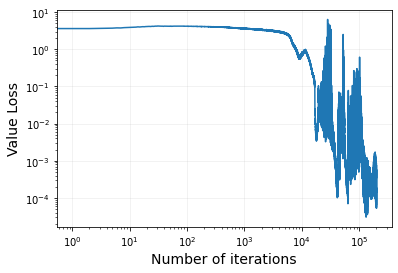

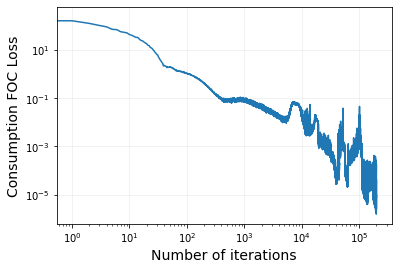

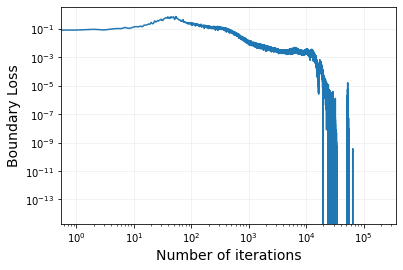

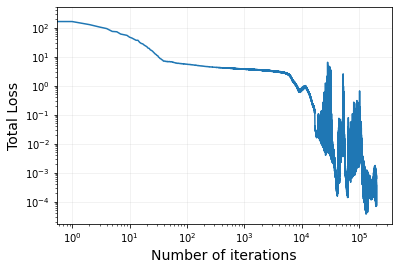

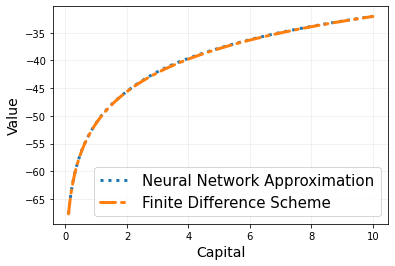

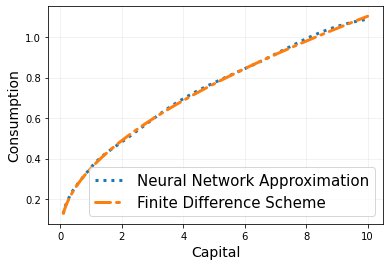

In [ ]:
###############################################################################
################################### Plotting ##################################
###############################################################################

# Define plotting grid
K = tf.cast(np.linspace(kMin, kMax, gridSize).reshape(gridSize, 1), tf.float32)

# Import reference results
reference_V = np.genfromtxt('/content/BEN_V.csv')
reference_C = np.genfromtxt('/content/BEN_C.csv')

#os.mkdir('results_policy_function_with_reference')
#os.chdir('results_policy_function_with_reference')

matplotlib.rcParams.update({'legend.fontsize': 15, 'axes.labelsize': 14, 'axes.titlesize': 14})
# Plot value loss function (as sqrt)
fig = plt.figure()
plt.plot(lossesV)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Value Loss')
# plt.title('Value Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('Value_Loss.png')

# Plot consumption FOC loss function (as sqrt)
fig = plt.figure()
plt.plot(lossesC)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Consumption FOC Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot boundary loss function
fig = plt.figure()
plt.plot(lossesB)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Boundary Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot Total loss (lossesV + lossesC + lossesB)
fig = plt.figure()
plt.plot(total_losses)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Total Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot value function
fig = plt.figure()
plt.plot(K, VF(K), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
plt.plot(K, reference_V, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xlabel('Capital')
plt.ylabel('Value')
# plt.title('Value Function')
plt.legend(loc = "lower right")
plt.grid(alpha=0.2)
#fig.savefig('Value_Function.png')

# Plot consumption policy function
fig = plt.figure()
plt.plot(K, tf.exp(CF(K)), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
plt.plot(K, reference_C, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xlabel('Capital')
plt.ylabel('Consumption')
# plt.title('Consumption Policy Function')
plt.legend(loc = "lower right")
plt.grid(alpha=0.2)
#fig.savefig('C_function.png')

In [ ]:
''' 
python 3 
This program checks for the current weather online and outputs the temperature and humidity in London 
'''

import requests
import json

def main():
    url = 'http://api.openweathermap.org/data/2.5/weather?q=London,uk&APPID=d1a7ed688e1b9155f95106d9a55b9ab0'
    response = requests.get(url)
    data = response.json()
    print(data)
    print(data['main']['temp'])
    print(data['main']['humidity'])

if __name__ == '__main__':
    main()

{'coord': {'lon': -0.1257, 'lat': 51.5085}, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04n'}], 'base': 'stations', 'main': {'temp': 281.1, 'feels_like': 278.57, 'temp_min': 279.64, 'temp_max': 282.13, 'pressure': 1019, 'humidity': 79}, 'visibility': 10000, 'wind': {'speed': 4.12, 'deg': 310}, 'clouds': {'all': 75}, 'dt': 1636049696, 'sys': {'type': 2, 'id': 2019646, 'country': 'GB', 'sunrise': 1636009165, 'sunset': 1636043320}, 'timezone': 0, 'id': 2643743, 'name': 'London', 'cod': 200}
281.1
79


Miscellanea: 

*   For an introductory course on Deep Learning, see [GoogleDeepmind x University College of London ](https://www.youtube.com/watch?v=7R52wiUgxZI&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=1&ab_channel=DeepMind)
*   For other Colab notebooks to learn Deep Learning see the [online material from the book "deep learning with python" by F.Chollet.](https://github.com/fchollet/deep-learning-with-python-notebooks)
* Google colab offers free GPUs (Runtime -> Change Runtime type). However, in this particular exercise, because of the small dimensions of our neural network, it is actually faster to use the CPU. If you suspect your NN is big enough to gain from GPU acceleration, run a few epochs using both and see by yourself which one goes faster.   

* If for your particular problem you see that it has not yet converged, it could be for different reasons. The most commons: 
    * Has it been running for enough epochs? If the graph *losses* looks like it would keep decreasing, this could be a solution.  
    * Have all constraints been included (e.g. boundary conditions)? Plot all relevant variables and check whether the values make sense or are too high/low/negative.  
    * maybe *dt* is too small: i.e. the real dynamics would lead to values crossing the boundary, but because *dt* is too small, but in the approximations it doesn't. Compensate sampling a bigger batch (increasing the chance that a boundary violation will happen) or bigger dt. 
    * maybe *dt* is too big: in the real dynamics we do not cross the boundary, but because *dt* is too big, it looks like we do. Try a smaller *dt*.
    * Boundary conditions keep being violated and you checked everything else? Maybe $\Psi$ is not big enough. 
    * The output is Nan (not a number): maybe in some point of the simulation, some elements went to infinity (usually because of a division by 0). Try tf.where( Variable_going_to_inf > 1E-7 , Variable_going_to_inf, 1E-7) or Variable_going_to_inf = tf.maximum(Variable_going_to_inf, 1E-7). 


$ $



Authors: 

Jesús Fernández-Villaverde (University of Pennsylvania, NBER and CEPR)

Roberto-Rafael Maura-Rivero (London School of Economics)

Galo Nuño (Banco de España) 

George Sorg-Langhans (Princeton University)

Maximilian Vogler (Princeton University)



